<a href="https://colab.research.google.com/github/ReyhaneAskari/test_repo/blob/master/Lab_8_Pytorch_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 8 - Intro to PyTorch

Previously, we've been using `numpy` to do mathematical calculations and make our statistical machine learning models run quickly. But now, we'll be looking at neural networks, where we will want to mostly calculate lots and lots of neurons. Since our neurons are usually in the form $f(x) = h(wx + b)$ we tend to deal with __large matrix multiplications__ (as well as additions, etc...). Since our standard method of training is SGD, with mini-batches, we want to do these matrix multiplications across our whole batch, and the fastest way to do that is in __parallel__. The best hardware for that isn't the CPU we're used to working with but a __GPU!__ There are a number of libraries that are useful for creating neural networks and running them on GPU (Keras/Tensorflow, Chainer,...) but we will be using `PyTorch`


In [7]:
!pip install "wheel==0.34.2"
!pip install "scikit-learn==0.21.2"

     |████████████████████████████████| 6.7MB 7.7MB/s 
  Found existing installation: scikit-learn 0.22
    Uninstalling scikit-learn-0.22:
      Successfully uninstalled scikit-learn-0.22


In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

import torch

In [2]:
%pylab inline
import torch
print(torch.__version__)

Populating the interactive namespace from numpy and matplotlib
1.7.0+cu101


## PyTorch Tensors

Whereas `numpy` used `np.array` as the basic data structure, in `PyTorch` we will use the similar `torch.Tensor` which you can think of in the same way. The big difference is that `torch.Tensor` can also be moved to the GPU, where they use a library called `CUDA` under the hood to do calculations

In [3]:
a = torch.Tensor([1,2,3])
W = torch.randn(3,3)
b = torch.Tensor([4,5,6]).view(3,1)
print(W.mm(b))

tensor([[ 2.1003],
        [-6.9332],
        [ 4.1620]])


In [4]:
device = torch.device('cuda:0')    # we use 0 to specify the first GPU
a = a.to(device)
b = b.to(device)
c = torch.ones(3, device=device)
print(a + b + c)

tensor([[ 6.,  7.,  8.],
        [ 7.,  8.,  9.],
        [ 8.,  9., 10.]], device='cuda:0')


## Iris Classification in PyTorch

Let's load  `iris.txt` using the `sklearn` library, we can then preprocess the labels and convert them to one hot encoding


In [9]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

iris = datasets.load_iris()

# separate into train/test using sklearn
(x_train, x_test, y_train, y_test) = train_test_split(iris.data, iris.target)

num_features = x_train.shape[1]
num_classes = 3

# lets also convert our targets y to a one-hot encoding 
# e.g. 1 -> [0, 1, 0], 2 -> [0, 0 ,1]  
one_hot = OneHotEncoder(n_values=num_classes, sparse=False)
# fit_transform -> is just transform -> forward
y_train = one_hot.fit_transform(y_train.reshape(-1,1))
y_test = one_hot.transform(y_test.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Finally, we'll convert our data to `torch.Tensor` representations, and because we can only have operations between arguments of the same type so lets make everything a `float` as well

In [10]:
x_train = torch.from_numpy(x_train).float().to(device)
x_test = torch.from_numpy(x_test).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

## PyTorch Autograd




So far when doing gradient descent for various ML models we would compute the gradients manually to do the update. While this would be possible for very simple neural networks with no hidden layer, it would become very complicated and bothersome to do backpropagation for complex, deep neural networks.

To this end, we'd like to just build our neural network and have our library calculate the gradients necessary for backpropogation itself! `PyTorch` does this with `autograd` which keeps track of all your operations and the gradients associated with them.

To do this, we set `requires_grad = True` for the tensors we want to keep track of, and call `loss.backward()` to populate the `.grad` part of each tensor. In our case, this will be the `weights`.

We are going to compare manual gradient computations and automatic gradient computations on a very simple network for iris classification with MSE loss, and make sure these computations are equivalent.

In [23]:
### We initialize weights and parameters
torch.manual_seed(0)
torch.cuda.manual_seed(0)
# set requires_grad = True to track the gradients
weights = torch.randn(num_features, num_classes, device=device, requires_grad=True)

learning_rate = 2e-3
num_epochs = 50

losses = []

### We now perform Gradient Descent

for epoch in range(num_epochs):

    # QUESTION : compute the predictions and MSE loss
    # (Hint : torch.mm(x,y) is matrix multiplication in PyTorch)
    # preds = # predictions
    preds = torch.mm(x_train, weights)
    # loss = # MSE loss
    loss = ((y_train - preds) ** 2).mean()
    # item() -> gets a python scalar from a tensor with a single value
    losses.append(loss.item())

    ### MANUAL gradient computation
    # QUESTION : complete the gradient computation for MSE
    # grad_preds = # gradients wrt predictions
    # grad_w = # gradients wrt weights
    
    grad_preds = -2 * (y_train - preds) / (x_train.shape[0] * num_classes)
    grad_w = torch.mm(x_train.T, grad_preds)

    ### AUTO gradients computation
    loss.backward()
    
    # Let's make sure both computations are equivalent
    if not np.allclose(grad_w.tolist(), weights.grad.tolist()):
      raise BaseException('gradients are different !')

    ### Update the weights without changing the gradients
    with torch.no_grad():
      # access the gradient with weights.grad
      weights -= learning_rate * weights.grad
      
      # make sure to reset the gradient to 0 for our next calculation
      weights.grad.zero_()

Text(0, 0.5, 'mean squared loss')

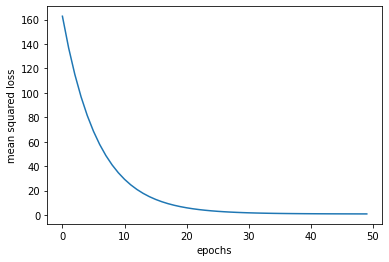

In [24]:
plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('mean squared loss')

## PyTorch Optimizers

We can make our code even simpler by letting the library do the gradient updates as well! Using `torch.optim` we can choose from a variety of optimization strategies, and in this case, we can use regular `SGD`. We have to specify all the parameters we wish to optimize, so in this case it is just `weights`

Text(0, 0.5, 'mean squared loss')

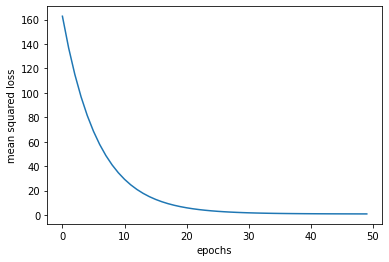

In [25]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
weights = torch.randn(num_features, num_classes, device=device, requires_grad=True)

learning_rate = 2e-3
num_epochs = 50
losses = []

# set the optimizer
optimizer = torch.optim.SGD([weights], lr=learning_rate)

for epoch in range(num_epochs):

    preds = torch.mm(x_train, weights)
    loss = (preds - y_train).pow(2).mean()
    losses.append(loss.item())

    # make sure to reset the gradients to 0 before calculation
    optimizer.zero_grad()
    loss.backward()
    # update our parameter with SGD
    optimizer.step()
    
plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('mean squared loss')

## PyTorch NN

Now nearly everything is in place, except it would still be a bit of a hassle to explicitly write out all the weights, biases, and other parameters we want to optimize. This is especially true since there are a lot of very common neural network building blocks that we use all the time. The `torch.nn` part of the libary is exactly that! It gives us all the tools to write our models at a higher level, going over the small details

Here, we will replace:
- `weights` with `nn.Linear` layer
- our optimizer's listing of parameters with `model.parameters()` 
- our manual loss calculation with `nn.MSELoss`

Text(0, 0.5, 'mean squared loss')

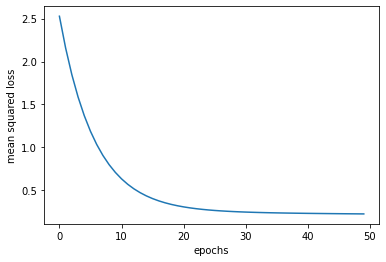

In [29]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# define your model
model = torch.nn.Linear(num_features, num_classes).to(device)
# check the parameters
params = model.named_parameters()
params.__next__()
params.__next__()
# choose a loss function
loss_fn = torch.nn.MSELoss()

num_epochs = 50
learning_rate = 2e-3
# automatically find all your model's parameters
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

losses = []

for epoch in range(num_epochs):
    preds = model(x_train)
    loss = loss_fn(preds, y_train)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('mean squared loss')

There are other types of layers besides `nn.Linear`. For example, we can add a non-linear activation such as ReLU with `nn.ReLU`, or add a convolution layer with `nn.Conv2d` (as we will see next week)

## PyTorch nn.Sequential
Most of the time we want to build multi-layer neural networks. PyTorch lets us do that by using [nn.Sequential](https://pytorch.org/docs/stable/nn.html?#sequential), which wraps a sequence of layers together and turns them into one big model. nn.Sequential is similar to sklearn's pipline.


Text(0, 0.5, 'mean squared loss')

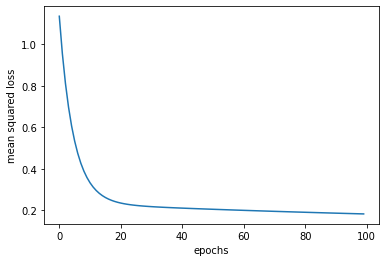

In [42]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Linear(num_features, 10),
    # torch.nn.ReLU(),
    torch.nn.Linear(10, num_classes)
).to(device)
    
loss_fn = torch.nn.MSELoss()

num_epochs = 100
learning_rate = 2e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

losses = []

for epoch in range(num_epochs):
    preds = model(x_train)
    loss = loss_fn(preds, y_train)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    

plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('mean squared loss')

## Challenge

We're now doing really well on the `iris` dataset mainly because it is so simple and neural networks are so powerful! Let's work on something a bit harder, and try our hands on the sklearn Digits dataset. This dataset contains images of handwritten digits, similarly to the famous MNIST, but with smaller dimension and size (to simplify the code in the scope of this demo)

There are 1797 images. The input images are handwritten digits (0 - 9) in a 8x8 pixel grayscale image. This means the input is a Tensor of size `1797 x 64` where each value is an "intensity" (how dark the pixel is) number between 0 and 255 (inclusive) . The output is the number that this handwritten image is showing, so between 0 and 9.

We now try using neural networks coded in PyTorch to handle this classification task. The loss function we use is softmax cross entropy (look [here](https://pytorch.org/docs/stable/nn.html?#loss-functions)).
The following code cell has an example of decently performing neural net. It is now your turn to play with the architecture and hyperparameters and see how it affects training score, test score, computation speed, etc. Try to improve the performances !

You can play with :

* number of layers
* number of neurons per layers
* device (cpu vs cuda, how does it impact speed ?)
* adding non-linear layers between linear layers (e.g. ReLU, but there are others)
* learning rate
* number of epochs
* loss function

Note that the dataset has a small number of samples and we are not using convolution layers (which are more adapted to images and which we will study next week), so the performance will have some limitations.

train accuracy : 0.9695619896065331
test accuracy : 0.9377777777777778


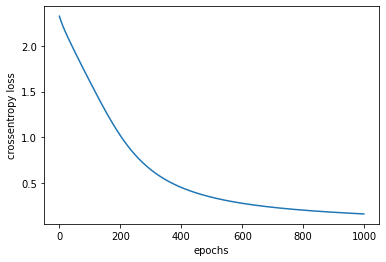

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

torch.manual_seed(0)
torch.cuda.manual_seed(0)
device = torch.device('cuda:0')

### Load Digits dataset

digits = datasets.load_digits()
(x_train, x_test, y_train, y_test) = train_test_split(digits.data, digits.target)
num_train = x_train.shape[0]
num_test = x_test.shape[0]
num_features = x_train.shape[1]
num_classes = 10

x_train = torch.from_numpy(x_train).float().to(device)
x_test = torch.from_numpy(x_test).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

### Hyperparameters & architecture

model = nn.Sequential(
    nn.Linear(num_features, 200),
    nn.ReLU(),
    nn.Linear(200, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, num_classes),
).to(device)

num_epochs = 1000
learning_rate = 2e-3
loss_fn = nn.CrossEntropyLoss()

### Training

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(num_epochs):

    preds = model(x_train)
    loss = loss_fn(preds, y_train)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    

### Results
    
plot(range(num_epochs), losses)
xlabel('epochs')
ylabel('crossentropy loss')

preds_train = model(x_train)
acc = 0
for i in range(len(y_train)):
  if torch.argmax(preds_train[i]) == y_train[i]:
    acc += 1
print('train accuracy : {}'.format(acc / len(y_train)))

preds_test = model(x_test)
acc = 0
for i in range(len(y_test)):
  if torch.argmax(preds_test[i]) == y_test[i]:
    acc += 1
print('test accuracy : {}'.format(acc / len(y_test)))
